# I.  Semantic Analysis:  Introduction

So far in this course we've dealt predominantly with data analysis methods rooted in descriptive statistics. In this module, we will move beyond descriptive methods and implement three machine learning techniques designed to model textual semantics:  Term Frequency Inverse Document Frequency (TFIDF), Topic Modeling, and Word Embedding.

The goal of each these processes is to program the computer to 'intuit' the semantic meaning texts.  The machine learning approach taken by each of these methods is, however, fundamentally different.  TFIDF is based on a conceptual model of language uniqueness as a gauge of importance; Topic modeling represents a 'Bag of Words" (or Bayesean, to be more formal) approach to the problem of semantics that throws out text structure and focuses on the cooccurrence of words across an entire text; and Word Embeddings implement a neural network (Deep Learning) approach to the problem that considers the proximity of words to each other in their original textual structure.  We'll explain more about each of these approaches as they are described.  Taken as a group, they represent three primary branches of machine learning that dominate the current state of the art in advanced textual analysis.

# II.  Environment Setup

You'll need to prepare you environment to perform the tasks in this notebook.  When executed, the code cell below will load those packages and modules needed to perform the activities presented in this course module.  Comments in the code identify each of the packages being loaded.  In each case, you can refer to the package documentation for more specific information about the package being used.  You must run the code cells below to properly prepare your environment to perform the text mining and analysis tasks presented in this module.  Note that several times during this process you will be asked to restart your session.  Do this each time when asked.

In [ ]:
# update collab environment to latest version of NLTK
# documentation: https://www.nltk.org/
!pip install nltk -U

In [ ]:
# we also need to install the ldavis/gensim connector package
!pip install pyLDAvis

In [ ]:
# and now we need to update pyLDAvis to the latest version
!pip install pyLDAvis -U

In [ ]:
# lets also make sure that we have the latest version of gensim
! pip install gensim -U

In [ ]:
# install the tmtoolkit for parameter estimation
! pip install tmtoolkit

In [ ]:
# install word2vec
! pip install word2vec

In [ ]:
# install lda package
! pip install lda

In [ ]:
# import the base nltk package 
# https://www.nltk.org/
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
# download nltk language models 
nltk.download('punkt')
nltk.download('stopwords')

# import regular expression package 
# https://docs.python.org/3/library/re.html
import re

# import numpy 
# https://numpy.org/
import numpy as np

# import pandas 
# https://pandas.pydata.org/
import pandas as pd

# import pprint main package
from pprint import pprint

# import the os package 
# https://docs.python.org/3/library/os.html 
import os

# import main Gensim package
# https://radimrehurek.com/gensim/
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# import ldavize package for model visualization
# https://pyldavis.readthedocs.io/en/latest
import pyLDAvis
from pyLDAvis import gensim_models

# import lda package
# https://lda.readthedocs.io/en/latest/
import lda

# import the matplotlib package for plotting
# https://matplotlib.org/stable/contents.htm
import matplotlib.pyplot as plt

# setup matplot lib to work from commandline
%matplotlib inline

# import the tmtoolkit
# https://tmtoolkit.readthedocs.io/en/latest/
import tmtoolkit
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod import tm_gensim
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.visualize import plot_eval_results

# import scipy package
# https://www.scipy.org/
import scipy
from scipy.sparse import coo_matrix

# import six package
# https://pypi.org/project/six/
import six

# import smart_open package
# https://pypi.org/project/smart-open/
import smart_open

# import word2vec package
# https://radimrehurek.com/gensim/models/word2vec.html
import word2vec

You also need to setup some system configuration to control error messages and logging.

In [4]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# disable deprication warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# III.  Load a Working Corpus

Before you can load files for analysis, you must mount your Google Drive in this environment.

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')

Once your Google Drive has successfully mounted, you can choose to work with the sample data provided for the course or to work with a corpus of your own.  For those who choose to work with course sample data, we'll be working with a small, randomly selected subset of eebo-tcp texts.  If you want to work with your own corpus, you'll put all of the text files that you want to model in a single directory in the "data_my" directory of the Course Home Directory. Note that the machine learning processes we will cover in this module can be quite computationally intensive, so you won't want to work, during class time, with a corpus of more than a couple hundred documents.  Depending on whether you intend to work on the sample data or on your own corpus, please follow the appropriate instructions below:

1.   To load the course sample corpus, simply run the cell without making any changes.
2.   To load a corpus of your own, comment out the first line, replace the "\<directory_name\>" substring in the line that reads, "working_file_directory_path = '/gdrive/MyDrive/rbs_digital_approaches_2021/data_my/\<directory_name\>/'" with the name of your directory, uncomment the line, and then run the cell.

In [6]:
working_file_directory_path = "/gdrive/MyDrive/rbs_digital_approaches_2021/s2_data_class/eebo-tcp/"
# working_file_directory_path = "/gdrive/MyDrive/rbs_digital_approaches_2021/data_my/<directory_name>/"

Now that we've defined a set of texts with which we want to work, we can being loading the corpus.

In [7]:
# first, we have to get a list of all files in the
# designated corpus directory
file_list = os.listdir(working_file_directory_path) 

Print the list to make sure that you retrieved it successfully.

In [ ]:
print(file_list)

Now that we know which files we need to load, we can begin reading the files into memory.  Below, we'll create an empty list to hold the full text of the documents in our corpus and then loop through each document, open the file, and then append the contents to the end of the list.

In [9]:
# define an empty list object to hold the texts
text_collection = []
# loop through our list of filenames and process each one
for nextfile in file_list:
  # join the corpus working directory path to the filename to create 
  # a full path name to the file
  next_file_path = working_file_directory_path + nextfile
  # open the designated file
  next_file_object = open(next_file_path, "r", encoding='windows-1252')
  # reada the contents into a variable
  next_text = next_file_object.read()
  # append the contents to the end of the corpus text list
  text_collection.append(next_text)
  # close the file object
  next_file_object.close()

Take a look at a text from the list.  Feel free to change the reference index and look at multiple texts.

In [ ]:
print(text_collection[0])

Create a "list of lists" where each top item in the list is a text and each text is associated with another, ordered list of words that constitue the text.

In [11]:
# pare each text into tokens
tokens = [simple_preprocess(next_doc, deacc=True) for next_doc in text_collection]


In [ ]:
# view the token list for a few texts. (Change the index number
# to change the text you are viewing.)
print(tokens[23])

Now we have the entire corpus stored in a list of lists, where each item at the top level of the list is an individual text, and each individual text is defined by an ordered list of the words that belong to it.  

The next thing we need to do is to start creating a Document Term Matrix (DTM) for the corpus.  The DTM is a standard data structure for representing texts for Bayesian, Bag of Words (BOW), approaches to analysis.  It is created by analyzing the frequency with which words cooccur across all texts in a given corpus.  BOW approaches ignore grammar and syntax and model semantics based simply on frequency of cooccurrence in the same text.  This approach may seem quite naive; however, as you will see, it works quite well.


In [13]:
# our first step is to create a 'dictionary' for the corpus,
# which is a unique accounting of all words that appear in all documents.
gensim_dictionary = corpora.Dictionary()
# next, we create a 'corpus' representation of the texts, which
# involves calculating the word frequencies in each individual text
# of every word in the dictionary 
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in tokens]

In [ ]:
# get a high-altitude view of our dictionary
print(gensim_dictionary)

In [ ]:
# and let's also look at the corpus.  The code output is a list of ID numbers
# from the dictionary paired with the frequency with which that item appears
# in the text.
print(gensim_corpus[0])

In [ ]:
# and here's another view that replaces the vocabulary ID with the word
# itself from the dictionary
bow_word_frequencies = [[(gensim_dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
print(bow_word_frequencies[:50])

# IV.  Term Frequency Inverse Document Frequency (TFIDF)

TFIDF is one of earliest developed attempts to semantically differentiate texts, and it is still one of the most widely used.  The primary goal of TFIDF is to identify the words that are most unique to a single text as compared to the words that appear in every other text in the corpus of analysis.

This is accomplished, as the name implies, by calculating the relative frequency of word in a single text as an inverse ratio to the relative frequency of the term across all documents in the corpus.  Once you have calculated TFIDF across all texts in a corpus, you can compare the TFIDF rankings of the words in the text (best method is through Principal Component Analysis) to determine which texts are most similar to each other.

Happily, the Gensim package contains functions for calculating TFIDF, so you don't have to program the math to take advantage of the process.

In [17]:
# instantiate a gensim tfidf model object using the gensim corpus
# note the 'smartiris' parameter.  This stands for
# System for the Mechanical Analysis and Retrieval of Text) Information Retrieval System
# a data structure for representing TFIDF data that was
# develped at Cornell Univeristy in the 1960's.  'ntc'
# designates the origal, triples data structure.  This has
# computational implications but no functional implications.
# 
# NOTE:  TfidfModel is a Class that is defined in the Gensim package.
# Instantiating a Class object does not actually perform an computation.
# It simply creates the object and sets its parameters for future use.

tfidf = models.TfidfModel(gensim_corpus, smartirs='ntc')

In [18]:
# here we actually invoke our tfidf object, running it on
# our tfidf corpus and, then, for each text that entry
# we add the results (stored in the 'sent' variable)a list

# create an empy tfidf list
tfidf_list = []

# run the tfidf model on the corpus then
# loop through all tfidf text representations, storing each
# in a variable called 'sent' for the duration of that loop
for next_text in tfidf[gensim_corpus]:
    # append the data from the tfidf text representation stored in the sent
    # variable to the tfidf_list list
    tfidf_list.append([[gensim_dictionary[id], np.around(frequency, decimals=2)] for id, frequency in next_text])

Now we have a list, where each row represents a single text in our corpus and contains a list of tuples for each word, where the first item in the tuple is the word and the second is its TFIDF ranking.  The higher the ranking, the more unique the word is to the individual text as compared to all other texts in the corpus.  To look at different texts, change the index that you are looking at and re-run the code cell.

In [ ]:
print(tfidf_list[0])

The above code gives us a view of the TFIDF data for each text, but it is difficult to find the most important words because it is not sorted, so lets go ahead and sort it.

In [ ]:
# Python program to sort a list of
# tuples by the second Item using sort() 
  
# Function to sort hte list by second item of tuple
def Sort_Tuple(tup): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of 
    # sublist lambda has been used 
    tup.sort(key = lambda x: x[1]) 
    return tup 
  
# printing the sorted list of tuples
print(Sort_Tuple(tfidf_list[0]))

# V. Topic Modeling

Topic Modelling is one of the most used and least understood semantic text analysis methods in the Digital Humanities / Cultural Heritage domain.  Because it is so poorly understood, it is almost always applied incorrectly or poorly and/or mis-interpreted after the fact. 

Perhaps the most misunderstood aspect of Topic Modeling is that it describes a class of analysis and not a specific mathematic or computational process.  Many different algorithms can be used to develop and implement Topic Models.  In this course, we will be using an algorithm called Latent Dirichlet Allocation (LDA), which was originally developed by David Blei, et al at Stanford University in 2003.  But Data Scientists frequently use a variety of algorithms to develop and implement topic models based on factors such as:  1) hardware specifications of the computing system running the process; 2) identified features of the corpus being analyzed, and 3) known performance differences and/or tendencies of the algorithms themselves.  LDA is featured in this course because it is the most frequently applied algorithm in the Digital Humanities, so understanding how it functions will allow you to better understand the majority of the extant Digital Humanities oriented literature and to conduct and present your own research in a manner that is most understandable to the rest of the cultural heritage community.

Careful readers will have noticed that I twice, above, described the application of Topic Models as one in which researchers both "develop and implement" Topic Models.  This phrasing is used intentionally because it makes explicit another little understand aspect of Topic Modeling:  that it is actually a two stage process, each stage of which can be performed independently, and each of which leads to its own, distinct, research findings.

# VI.  Topic Modeling Stage 1:  Fitting the Model to the Semantic Universe of the Corpus



When thinking about Topic Models, most people (and most academic papers) jump straight to thinking about identifying the topics that are present in a particular text.  We want to know, for example, what the most important topics are in a novel like *Moby Dick*.  But this is putting the cart before the horse.  The seminal purpose of a Topic Model is, as the name implies, to model the semantic universe.  You can't know what topics appear in Moby Dick unless you know what topics exist to begin with.

When we build a Topic Model, we are literally building of model of all of the topics that exist in the textual universe of interest.  These models are developed by using algorithms like LDA to computationally 'read' a collection of texts and report back on the entirety of topics that the computer determines are present in the corpus.  This list of topics, and their mathematical definitions, constitute the "Model" in Topic Modeling.

For a topic model to be computationally useful, it has to be stored (as a file or in computer memory assigned to variable of some type) in a machine readable format.  A .png file that depicted a collection of emojis that represented each topic would be computationally intractable.  LDA models are stored as large, 2 dimensional matrices where each column/variable represents a topic and each row/observation represents a unique word from the entire vocabulary found in the texts on which the model was developed (a Dictionary). The intersecting cells of the matrix contain the LDA calculated probability that a word will appear in a text if an associated topic is present in that text.  This structure is most commonly known as the "Topic Terms" or "Topic Words" matrix.  The image below depicts a small segment of a Topic Model trained on public comments posted to an FDA solicitation for comment on a proposed food labelling law.

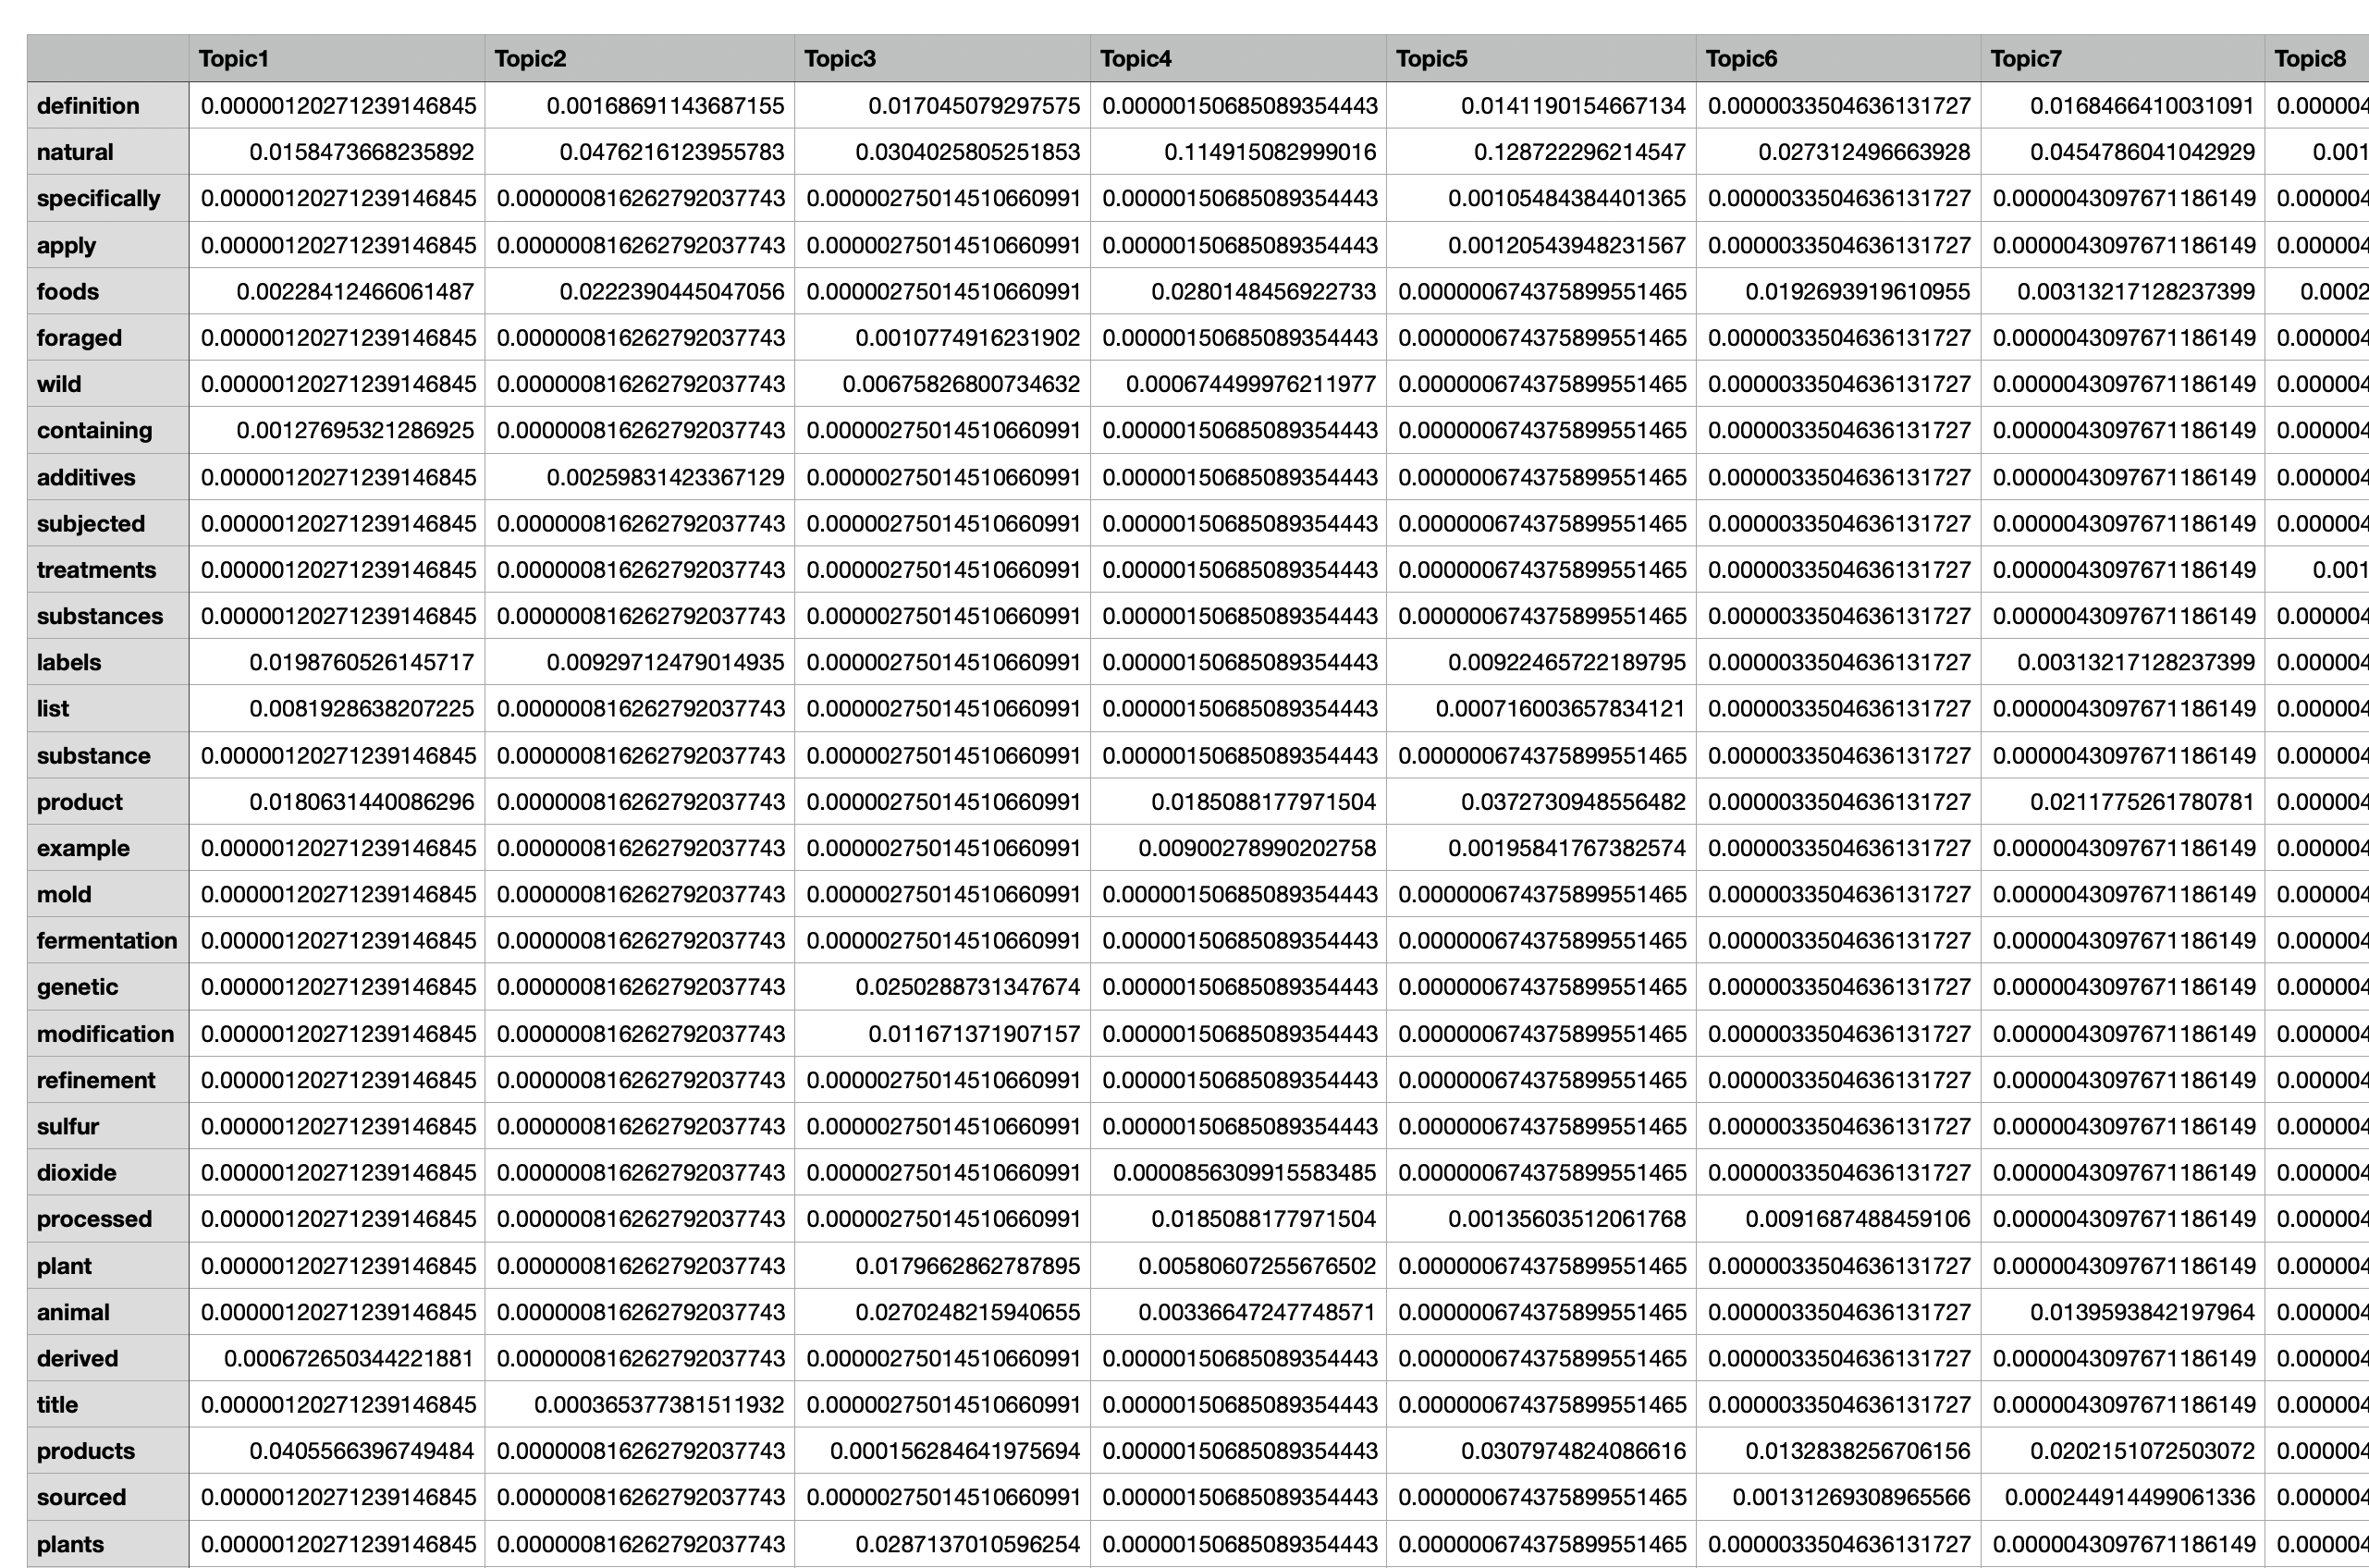

# VII.  Topic Modelling Stage 2:  Fitting Individual Texts to the Model

A tremendous amount can be learned about a corpus simply by developing and interrogating a Topic Model, without ever examining how individual texts relate to the model. (We’ll see this during our next class discussion period.) But often we are concerned with understanding the topics that are present in a single text (text *a* is about *x*, *y*, and *z*), or in classifying texts based on the presence of certain topics (show me all texts that are about topic *x*).  In Model theory, the process of taking a dataset (in our case, a text) and comparing it to an existing model to determine the extent to which it does or does not look like the model, or what parts of the model it does or does not look like, is known as *model fitting*.  By extension, when we compare any single text or a group of texts to a model we say that we *fit* the text(s) to the model.  

In the case of Topic Modeling, 'fit' manifests itself in the mathematical likelihood of any topic found in the model being present in the text being fit. In our case, we will use the same Dirichlet process to both build and fit the model; however, this isn't necessary.  You could, in fact, hand create and curate a model and then fit texts to this model, provided you instantiated the model using a data structure that is understandable to the fitting algorithm.  Another often misunderstood aspect of Topic Modeling is the untrue belief that that you can only fit texts to a model that was created using those same texts.  In fact, you can develop a Topic Model on one corpus of texts and then "fit" a completely different collection of texts to that model. This is extremely useful when performing comparative analysis and also when trying to classify texts that were unavailable at the time of model development.  You could also use two completely different algorithms to develop and fit your model.

In this exercise we will use LDA to fit texts to a model, and the results of this fitting will be stored as a 2-dimensional matrix known as a "Document Topics" or "Doc Topics" matrix that is similar in structure to the Topic Terms matrix described above, with each column/variable representing a topic and each row/observation representing a text that was fit to the model.  The individual cells of the matrix represent the likelihood that the a given topic is present in a given text.  The image below depicts a small segment of a Doc Topics matrix:

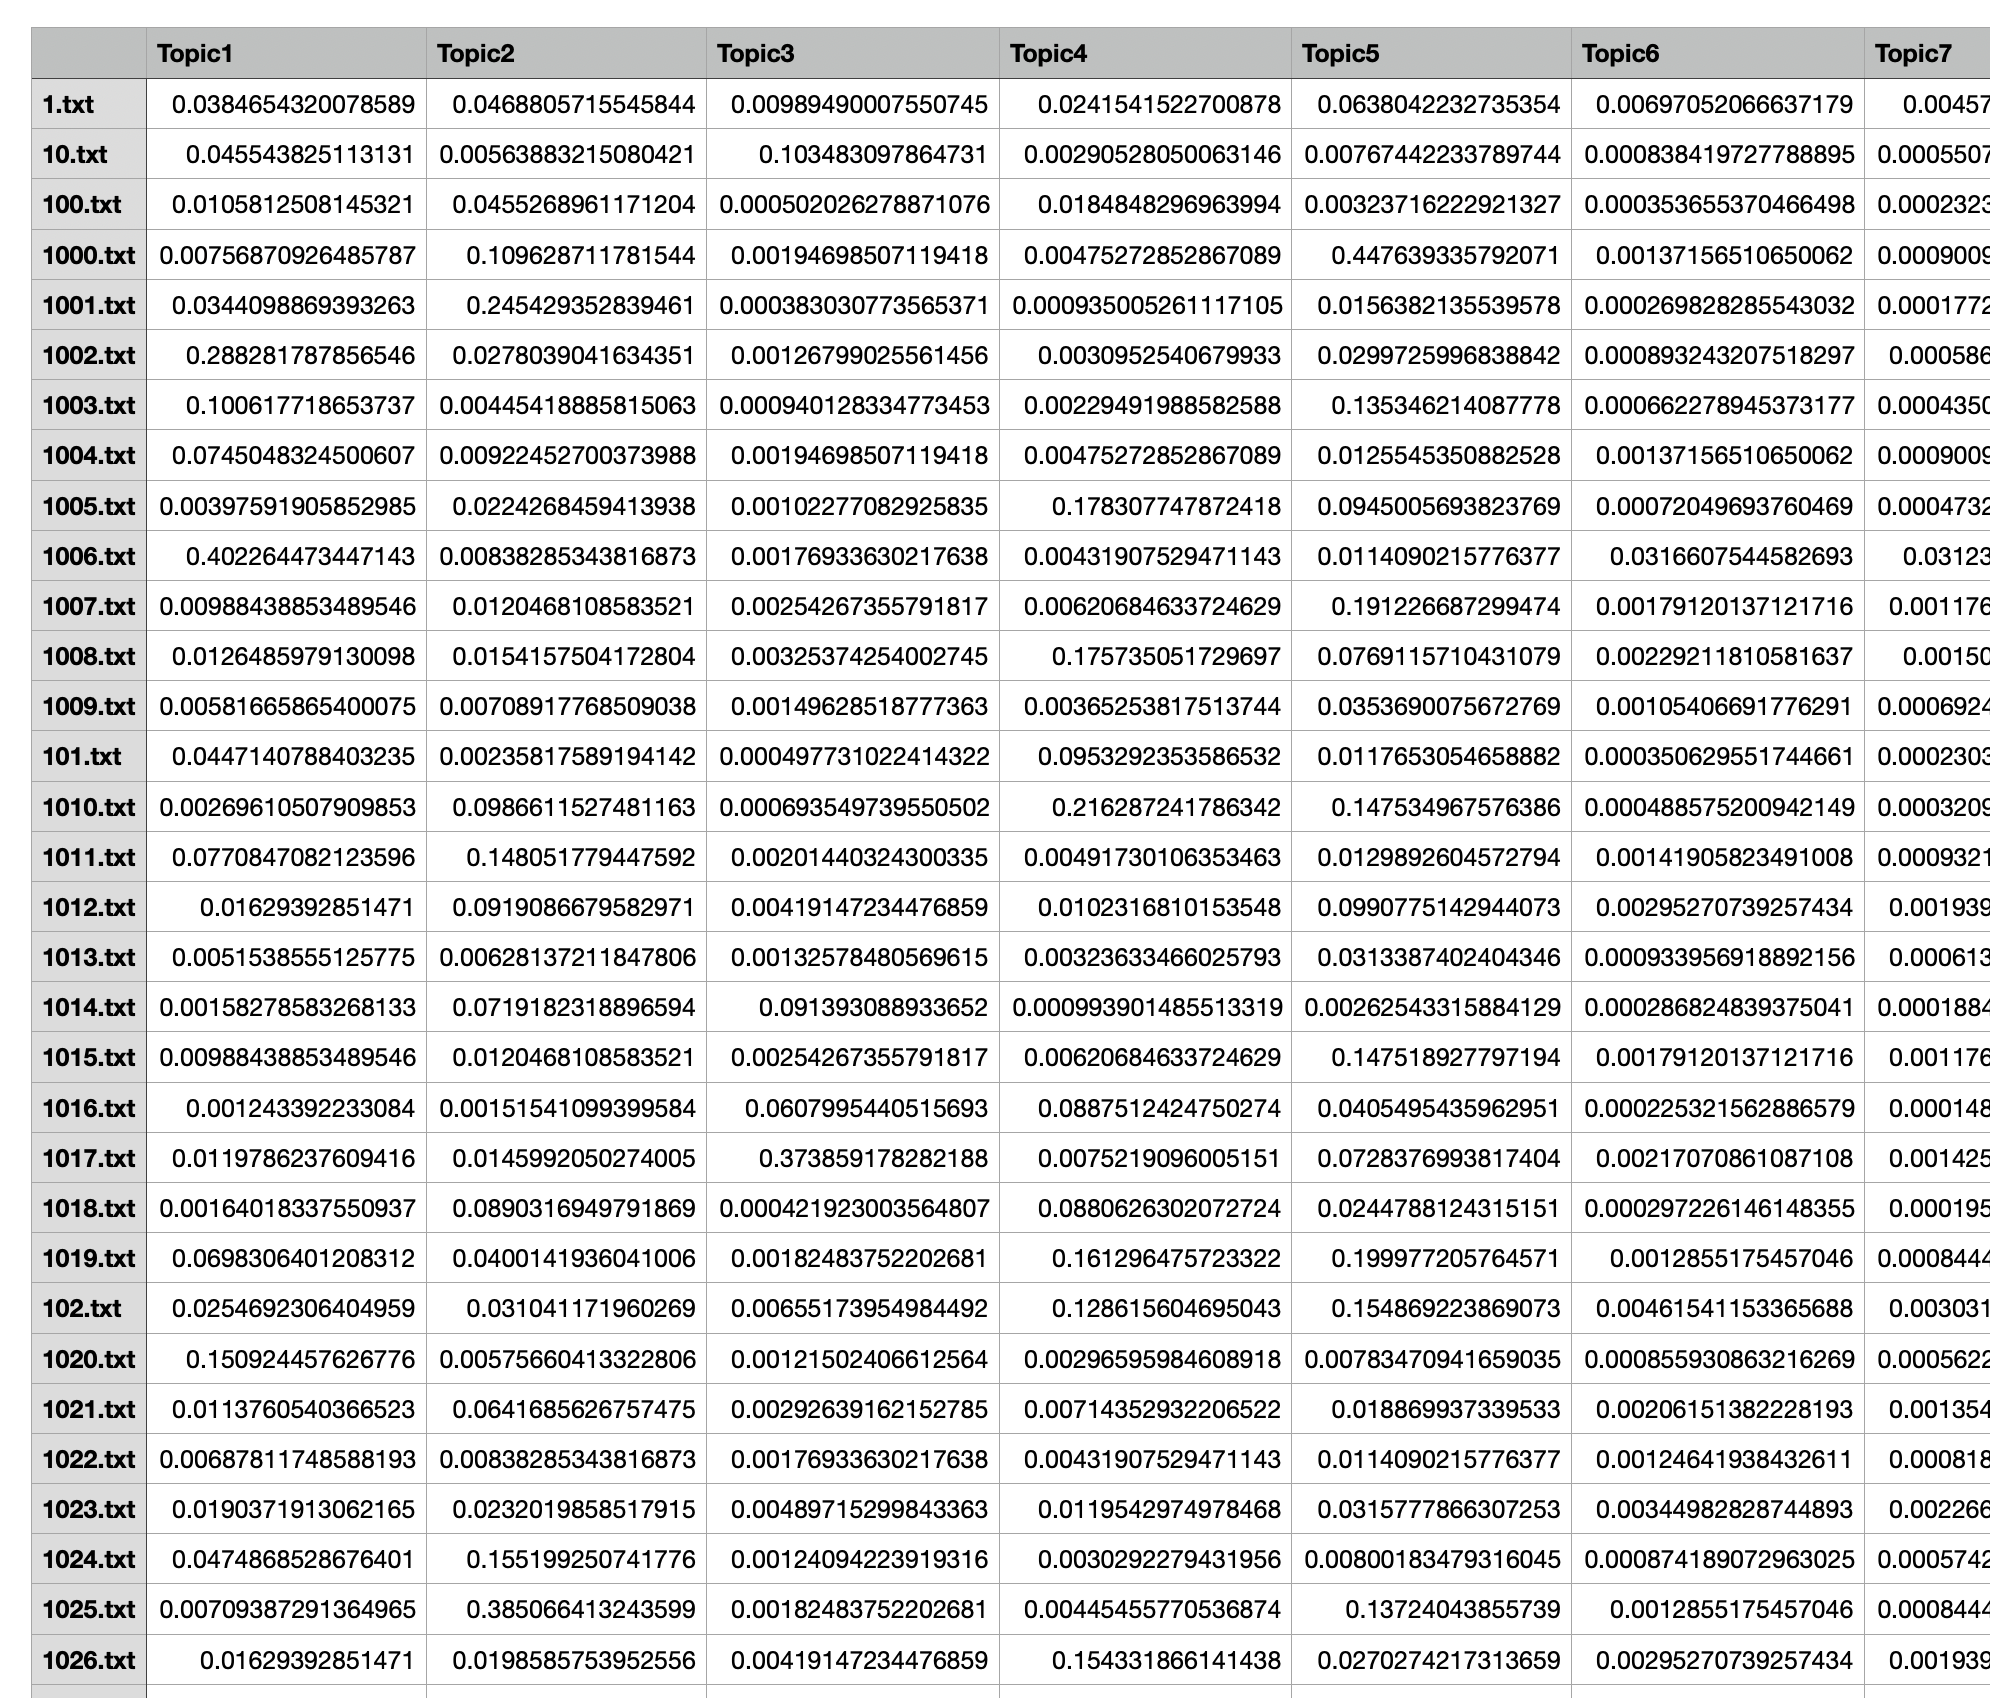

# VIII.  Topic Model "Tuning"

You will frequently hear people talking about Topic Model "Tuning."  This is because algorithms like LDA are what statisticians refer to as *parametric* algorithms, because it is necessary to set values for a set of parameters *prior* to running the algorithm. These parameters, which are frequently referred to simply as *priors* or *hyperparameters* have a significant impact on the models they produce and on how individual texts are fit to these models.  Unfortunately, most people determine the values for their parameters by repeatedly running the model with different priors until the final output looks "reasonable," which another way saying, "how I expected it to look." 

In statistics, this process is known as *overfitting*.  And you should be very afraid of doing it yourself and/or the output of any modeling process where the person who ran the model "tuned" the algorithm until the "model looked right."  In all likelihood, most models that are tuned this way are extremely accurate reflections of the biases of the person who tuned the model and very inaccurate reflections of the "ground truth" of the texts being modeled.  

Luckily, there are well established strategies for estimating accurate prior values.  Unfortunately, these methods are extremely computationally intensive and cannot be run effectively (if at all) in the free Google Collab environment.  As such, this notebook sets arbitrary values for the LDA priors.  However, the code necessary to properly estimate priors is provided at the end of the workbook and we will discuss how each parameter affects the LDA process and proper estimation techniques in detail during our discussion section.


# IX.  Building and Fitting a Topic Model: Step by Step

In this section we walk through all of code necessary to build an LDA model and then fit a collection of texts to the model.  As with parameter estimation (discussed above) LDA Topic Modeling is a computationally intensive process.  It is not uncommon for processes to run for several days, even on medium sized corpuses.  In order to be sensitive to time, this example runs on a very small collection of texts (just over 100) which is insufficient to train an accurate model.  

LDA functions at its best if the number of documents on which you train a model is equal to or greater than the size of the corpus vocabulary.  It will function reasonably well with significantly fewer texts than this golden number, but with the small size we are using here, the final model will have very little validity. The intent of this exercise is, therefore, for you to understand the process and the structure of the outputs rather than to actually interrogate the outputs.  During our discussion I will make models available that were run on the complete ebbo-tcp corpus, and we will interrogate them together. 


Since we've already done a great deal of text preparation and created a Gensim Dictionary, we can use these as the data sources for training and fitting our model.  You can also see all of the other priors that are being set below.  We will review all of these during our class discussion.  For now, simply note that we are telling the LDA to develop a model with 20 topics.  Also note that it may take some time for this cell to complete its execution.  Probably a good gime to hit play and refill your coffee!

In [22]:
# run the lda model using gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus, 
                                            id2word=gensim_dictionary,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

Now that we have a model, we can look at the structure

In [ ]:
#load ten words and their likelihood for each topic into list of lists
topics = lda_model.print_topics(num_words=10)
# for each top level item in our list of lists, print the sub list
for topic in topics:
    print(topic)

And now we can visualize the model

In [ ]:
# create an LDA Visualization Object
lda_viz = pyLDAvis.gensim_models.prepare(lda_model, gensim_corpus, gensim_dictionary)

#display the visualization
pyLDAvis.display(lda_viz)

# X. Word Embeddings

Word Embeddings describes a process of modelling the semantic context in which words appear (or are *embedded*).  The Word Embedding approach to semantic modeling utilizes a Convolutional Neural Network to analyze word context and develop a semantic definition of every word in the training corpus.

The results of the neural network training are what are known as "dense vector" representations of each word.  A Dense vector is an n-dimensional matrix in which each word is defined completely by its relationship to other words.  This means that if any single word establishes a new relationship, the definitions of every other word in the vocabulary also shift.

In the context of the word2vec package, which we will be using to create our word vectors, when we say that two words have a relationship, what we mean is that they appear in a text within a designated number of words from each other.  To determine this, the computer reads through the text in the proper order and direction, focusing on one word at a time.  When it is focused on a single word it counts words to the left and right until the total number of words equals a defined "window."  Any words found in the window are considered related and tabulated as such.  The computer then moves to the next word and starts again.  This process is repeated until the end of the text is reached.

The results of the skipgram relationship tabulation described above are then fed into a neural network which uses the information to create the codependent definitions of each word in dense vector form.  Once this matrix has been created, you make semantic comparisons between words by comparing their vector definitions.  The more mathematically similar any two vectors are, the more semantically similar the two words are.

In [25]:
# instantiate an instance of the gensim Word2Vec class
embeddings_model = gensim.models.Word2Vec(tokens, window=5, min_count=3)


In [26]:
# set the model vocabulary from the gensim model and define a notification period
embeddings_model.build_vocab(tokens, progress_per=10000)

In [ ]:
# now train the neural net
embeddings_model.train(tokens, total_examples=embeddings_model.corpus_count, epochs=30, report_delay=1)

Once we have our neural network trained, we can start asking questions about word semantics.   Play around with other words in which you might be interested.  But remember that this neural network was trained on a very small sample of texts, so don't put too much stock in what you find.

In [ ]:
# find the words most similar to a word of interest
embeddings_model.wv.most_similar(positive=["king"])

In [ ]:
# find the words least similar to a word of interest
embeddings_model.wv.most_similar(negative=["king"])

In [ ]:
# test the similarit of identified words
embeddings_model.wv.similarity("king", "lord")

# Appendix:  Topic Model Parameter Estimation and Evaluation

**DO NOT RUN CODE IN THIS SECTION DURING CLASS SESSION!**

This section of the workbook presents code for performing parameter estimation.  As noted earlier, it is very computationally intensive and will monopolize your Collab environment for several hours, even wehn running on a very small corpus.  The code will be discussed in discussion section and is prsented here for future use.

In [ ]:
# first we'll deine a function to create a dtm
def base_dtm(docs):
    vocab = set()
    for doc in docs:
        vocab |= set(doc.split(' '))
        
    counts = [dict.fromkeys(vocab, 0) for doc in docs]
    for idx, doc in enumerate(docs):
        for word in doc.split(' '):
            counts[idx][word] += 1
            
    dtm = [[count for count in doc.values()] for doc in counts]
    return dtm, list(vocab)


In [ ]:
# now, extract a dtm and our vocab list
dtm, vocab = base_dtm(text_collection)

In [ ]:
# convert the data type of our DTM to an array
dtm = np.asarray(dtm)

In [ ]:
var_params = [{'n_topics': k, 'alpha': 1/k} for k in range(20, 51, 10)]

In [ ]:
const_params = {
    'n_iter': 1000,
    'eta': 0.1,       # "eta" aka "beta"
    'random_state': 20191122  # to make results reproducible
}

In [ ]:
eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     return_models=True)

Now that we've run the analysis, let's explore it.

In [ ]:
# look at the first 3 tests
eval_results[:3] 

Now we'll take the “raw” evaluation results and sort them by a specific hyperparameter, in this case n_topics, to get ready to visualize the results of our analysis.

In [ ]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]  # again only the first three models

And now we can visualize the results

In [ ]:
plot_eval_results(eval_results_by_topics)

Locate the number ot topics where all three results are closest to 0.  This is your optimal number of topics based on overal word perplexity.